# Optimization in Machine Learning Exercise 2
Author: Csanády, Bálint px199@uni-heidelberg.de,
        Ma, Pingchuan P.Ma@stud.uni-heidelberg.de

In [1]:
import pulp
import random
import gzip
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
Node = namedtuple('Node', 'costs')
Edge = namedtuple('Edge', 'left right costs')

# Exercise 2.1

## Code

In [2]:
def convert_to_lp(nodes, edges, relaxed=True):
    model = pulp.LpProblem()
    YV=[]
    for i in range(len(nodes)):
        YV.append([])
        for j in range(len(nodes[i].costs)):
            if relaxed:
                YV[i].append(pulp.LpVariable("y"+str(i)+"."+str(j), 0, 1, 'Continuous'))
            else:
                YV[i].append(pulp.LpVariable("y"+str(i)+"."+str(j), 0, 1, 'Integer'))            
    for i in range(len(nodes)):
        model += pulp.lpSum(YV[i])==1
    YE={}
    for e in edges:
        YE[(e.left,e.right)]={}
        for j,k in e.costs:
            if relaxed:
                YE[(e.left,e.right)][(j,k)]=pulp.LpVariable("y"+str(e.left)+"."+str(e.right)+"."+str(j)+"."+str(k), 0, 1, 'Continuous')
            else:
                YE[(e.left,e.right)][(j,k)]=pulp.LpVariable("y"+str(e.left)+"."+str(e.right)+"."+str(j)+"."+str(k), 0, 1, 'Integer')
    #for e in edges:
        #model += pulp.lpSum(YE[(e.left,e.right)])==1
    for e in edges:
        for j in range(len(nodes[e.left].costs)):
            curr=[]
            for k in range(len(nodes[e.right].costs)):
                curr.append(YE[(e.left,e.right)][(j,k)])
            model += pulp.lpSum(curr)==YV[e.left][j]
        for j in range(len(nodes[e.right].costs)):
            curr=[]
            for k in range(len(nodes[e.left].costs)):
                curr.append(YE[(e.left,e.right)][(k,j)])
            model += pulp.lpSum(curr)==YV[e.right][j]
    model += (pulp.lpSum([pulp.lpSum([YV[i][j]*nodes[i].costs[j] for j in range(len(nodes[i].costs))]) for i in range(len(nodes))])
        +pulp.lpSum([pulp.lpSum([YE[(e.left,e.right)][(i,j)]*e.costs[(i,j)] for i,j in e.costs]) for e in edges]))
    #model.writeLP("tst.lp")
    return model,YV,YE
def convert_to_ilp(nodes, edges):
    return convert_to_lp(nodes, edges, False)
def showLP(YV,YE):
    for i in range(len(YV)):
        print("node "+str(i)+":")
        for j in range(len(YV[i])):
            print(str(j)+": "+str(YV[i][j].varValue))
    print('------')
    for i,j in YE:
        print("("+str(i)+","+str(j)+"):")
        for k,l in YE[(i,j)]:
            print("("+str(k)+","+str(l)+"): "+str(YE[(i,j)][(k,l)].varValue))
def ilp_to_labeling(YV):
    ret=[]
    for v in YV:
        for j in range(len(v)):
            if v[j].varValue==1.0:
                ret.append(j)
                break
    return ret

## Test

In [4]:
nodes = [Node(costs=[9.691, -2.3752, 0.0987]),
         Node(costs=[0.9986, -7.7079, 5.6862]),
         Node(costs=[-5.8935, -8.0664, 5.969]),
         Node(costs=[-4.3176, 8.1813, -1.2446]),
         Node(costs=[-1.6723, 0.6998, -3.6954])]

edges = [Edge(left=0, right=1, costs={(0, 0): -3.9159, (0, 1): 5.85, (0, 2): -4.7939, (1, 0): -7.8181, (1, 1): 5.4672, (1, 2): 7.7718, (2, 0): 5.8543, (2, 1): -6.8887, (2, 2): 1.7876}),
         Edge(left=0, right=2, costs={(0, 0): -6.4049, (0, 1): 8.904, (0, 2): -1.8938, (1, 0): -4.5657, (1, 1): -3.8663, (1, 2): -9.9305, (2, 0): -3.1055, (2, 1): -6.591, (2, 2): 8.9614}),
         Edge(left=0, right=3, costs={(0, 0): -1.0937, (0, 1): 1.0297, (0, 2): -7.8613, (1, 0): -7.5173, (1, 1): 8.2634, (1, 2): 5.5371, (2, 0): 5.2456, (2, 1): -1.1742, (2, 2): -1.4712}),
         Edge(left=0, right=4, costs={(0, 0): 5.2057, (0, 1): -5.1957, (0, 2): -5.2287, (1, 0): -0.8213, (1, 1): -4.3382, (1, 2): -4.3687, (2, 0): -3.2938, (2, 1): 3.1702, (2, 2): 8.4605}),
         Edge(left=1, right=2, costs={(0, 0): 7.4094, (0, 1): 4.8436, (0, 2): 0.9137, (1, 0): -4.4914, (1, 1): 4.7042, (1, 2): 0.4877, (2, 0): -9.5972, (2, 1): 6.2891, (2, 2): 9.1979}),
         Edge(left=1, right=3, costs={(0, 0): 7.5832, (0, 1): 3.7768, (0, 2): 1.347, (1, 0): -8.3239, (1, 1): -5.85, (1, 2): -6.5418, (2, 0): 1.4386, (2, 1): -0.7296, (2, 2): -2.7997}),
         Edge(left=1, right=4, costs={(0, 0): 3.3883, (0, 1): -7.1952, (0, 2): 8.1274, (1, 0): -8.503, (1, 1): -6.7619, (1, 2): -0.3693, (2, 0): -0.7216, (2, 1): 3.3241, (2, 2): 0.4973}),
         Edge(left=2, right=3, costs={(0, 0): 6.4853, (0, 1): -1.821, (0, 2): -1.5925, (1, 0): -6.3369, (1, 1): 8.4083, (1, 2): 6.6462, (2, 0): -4.9005, (2, 1): 3.2905, (2, 2): 0.849}),
         Edge(left=2, right=4, costs={(0, 0): 0.3729, (0, 1): -8.0883, (0, 2): 0.8122, (1, 0): 9.7608, (1, 1): 5.9125, (1, 2): -3.5372, (2, 0): 9.9937, (2, 1): 7.0355, (2, 2): -8.9403}),
         Edge(left=3, right=4, costs={(0, 0): 1.8368, (0, 1): 4.8559, (0, 2): 0.2353, (1, 0): 7.0079, (1, 1): -4.8822, (1, 2): -9.9903, (2, 0): 1.9393, (2, 1): -9.1514, (2, 2): 3.0298})]

ground_truth = ((2, 1, 0, 2, 1), -58.96999999999999)


def run_test():
    ilp,YV,YE = convert_to_ilp(nodes, edges)
    assert(ilp.solve())
    assert(tuple(ilp_to_labeling(YV)) == ground_truth[0])
    assert(abs(ilp.objective.value() - ground_truth[1]) < 1e-4)
    print("Success")
run_test()

Success


# Exercise 2.2

## Code

In [3]:
def lp_to_labeling(YV):
    ret=[]
    for v in YV:
        maxVal=0
        idx=-1
        for j in range(len(v)):
            if maxVal<v[j].varValue:
                maxVal=v[j].varValue
                idx=j
        ret.append(idx)
    return ret

## Test

In [6]:
nodes = [Node(costs=[-1.5061, -0.8021, 5.7174, 4.2437, -2.5396, -6.0331, -8.3109]),
         Node(costs=[-3.1566, 7.882, 3.5212, -3.3191, 7.3413, 6.3118, 0.3019]),
         Node(costs=[7.8413, -3.1581, 0.5155, -3.1008, -5.9668, -3.8839, 2.2935]),
         Node(costs=[-0.9236, -0.3661, -5.3091, 8.9676, 2.5754, 0.9249, 4.0608]),
         Node(costs=[7.8756, 9.3186, -4.8839, -7.8941, -7.0022, 0.7004, 2.0152]),
         Node(costs=[-1.0619, -5.2761, 6.7067, -5.1918, 5.0483, -3.0348, 4.7758]),
         Node(costs=[8.1674, 2.5738, 7.1906, -7.6213, -6.6305, 7.6042, -5.0493]),
         Node(costs=[-6.7696, -2.6383, -7.1781, -7.053, -6.8186, 6.1107, -4.2067]),
         Node(costs=[-1.2107, -8.0153, -6.5647, 3.6036, -9.2738, 1.0989, 5.2785]),
         Node(costs=[7.5919, -9.8517, 2.7283, 5.0519, -1.2976, -1.6965, -0.0229]),
         Node(costs=[2.025, 1.5594, -8.44, -8.0089, 0.4086, -5.7409, -4.5455]),
         Node(costs=[8.6545, 2.1026, -0.5683, -8.1914, -9.675, -7.1027, 6.05]),
         Node(costs=[-0.6644, 5.7139, 2.2223, -6.4137, 5.7952, -4.4957, 4.9225]),
         Node(costs=[-7.317, 4.2077, 3.756, 5.4135, 5.4073, 3.3342, -0.3287]),
         Node(costs=[-6.5044, 1.0493, 9.515, 5.5488, 0.8013, 1.8678, -0.6183]),
         Node(costs=[7.5503, -8.4853, 1.8696, 9.603, -1.1036, -7.0065, 6.2884]),
         Node(costs=[-0.3884, 7.1991, -0.9397, 2.7967, 6.8893, 8.2413, 5.28]),
         Node(costs=[-4.8675, -3.8155, -2.828, 6.9501, 1.9123, 4.9885, -0.6482]),
         Node(costs=[6.0459, 7.3598, 1.5121, -8.9582, 2.1502, 6.4544, -6.129]),
         Node(costs=[2.7919, 1.9317, 9.4457, -0.2656, -6.0179, -8.947, 5.7134]),
         Node(costs=[-9.4323, 6.7083, 3.4822, -2.5461, 4.3593, 0.1974, 4.8677])]

edges = [Edge(left=0, right=16, costs={(0, 0): 5.3564, (0, 1): -4.3685, (0, 2): 5.8853, (0, 3): 7.7939, (0, 4): -6.1302, (0, 5): 5.4067, (0, 6): 2.0335, (1, 0): -5.0459, (1, 1): -8.5007, (1, 2): -6.8801, (1, 3): -1.7732, (1, 4): -3.4862, (1, 5): 3.499, (1, 6): -1.0048, (2, 0): 5.3503, (2, 1): 9.1323, (2, 2): -7.3212, (2, 3): 4.7853, (2, 4): 6.6182, (2, 5): 0.0685, (2, 6): 9.9826, (3, 0): 4.6668, (3, 1): -8.5783, (3, 2): -2.6485, (3, 3): -6.0143, (3, 4): 8.0355, (3, 5): 2.2717, (3, 6): 8.3998, (4, 0): -9.8806, (4, 1): -7.5892, (4, 2): 1.3081, (4, 3): 6.2326, (4, 4): -3.6079, (4, 5): 5.0421, (4, 6): 9.132, (5, 0): 2.2267, (5, 1): -5.5942, (5, 2): -6.0044, (5, 3): -8.4498, (5, 4): -1.8324, (5, 5): 3.77, (5, 6): -9.5943, (6, 0): 9.2929, (6, 1): -7.7375, (6, 2): -1.1919, (6, 3): -6.4641, (6, 4): -4.7802, (6, 5): -7.4799, (6, 6): 1.2368}),
         Edge(left=1, right=16, costs={(0, 0): -9.7434, (0, 1): 7.0869, (0, 2): -2.4695, (0, 3): 8.9713, (0, 4): -7.0451, (0, 5): 9.9417, (0, 6): 5.7555, (1, 0): 2.5774, (1, 1): 3.2324, (1, 2): -5.4853, (1, 3): -0.0608, (1, 4): 3.8037, (1, 5): -2.4923, (1, 6): -9.0214, (2, 0): 5.1344, (2, 1): -0.7058, (2, 2): 8.4013, (2, 3): -1.6762, (2, 4): 4.0326, (2, 5): -3.1223, (2, 6): 8.1721, (3, 0): 8.2603, (3, 1): 0.1829, (3, 2): -5.8599, (3, 3): 0.4782, (3, 4): -9.2233, (3, 5): 1.1962, (3, 6): -6.4607, (4, 0): 3.0273, (4, 1): 9.4097, (4, 2): -1.6169, (4, 3): -1.8224, (4, 4): -7.4631, (4, 5): -8.8982, (4, 6): 7.8582, (5, 0): -2.2382, (5, 1): 4.1091, (5, 2): -1.7647, (5, 3): -0.3652, (5, 4): -9.4339, (5, 5): 9.0012, (5, 6): 7.0933, (6, 0): 8.1522, (6, 1): -0.2759, (6, 2): -4.9225, (6, 3): -2.4244, (6, 4): 1.125, (6, 5): 4.5095, (6, 6): -1.8918}),
         Edge(left=2, right=16, costs={(0, 0): -6.6252, (0, 1): -3.464, (0, 2): -1.741, (0, 3): 1.9404, (0, 4): -7.995, (0, 5): 8.6507, (0, 6): 9.1972, (1, 0): -7.9724, (1, 1): -2.6698, (1, 2): 7.2017, (1, 3): -6.4352, (1, 4): 5.1455, (1, 5): -4.7049, (1, 6): 0.1736, (2, 0): 5.9907, (2, 1): -6.4236, (2, 2): 7.3983, (2, 3): -8.609, (2, 4): 9.8519, (2, 5): -1.3674, (2, 6): -8.7923, (3, 0): -2.2964, (3, 1): -7.2155, (3, 2): -4.9235, (3, 3): 2.8741, (3, 4): 4.1699, (3, 5): 0.1081, (3, 6): -4.2784, (4, 0): -0.112, (4, 1): -8.5105, (4, 2): 9.8412, (4, 3): -5.7914, (4, 4): 9.3831, (4, 5): 0.0707, (4, 6): -1.1483, (5, 0): 4.3002, (5, 1): 0.9781, (5, 2): -2.0829, (5, 3): 7.9491, (5, 4): 2.6309, (5, 5): -9.0046, (5, 6): 0.7583, (6, 0): 5.7701, (6, 1): -5.7768, (6, 2): 8.6983, (6, 3): -1.3369, (6, 4): -7.8309, (6, 5): -4.6359, (6, 6): 8.6182}),
         Edge(left=3, right=16, costs={(0, 0): 4.6182, (0, 1): -0.6164, (0, 2): -1.8459, (0, 3): -5.4417, (0, 4): -9.8664, (0, 5): 1.777, (0, 6): 5.9356, (1, 0): 9.5346, (1, 1): -4.0799, (1, 2): -0.2995, (1, 3): -4.3292, (1, 4): 6.3577, (1, 5): 6.5637, (1, 6): -0.8676, (2, 0): -6.5078, (2, 1): 6.5783, (2, 2): -2.0997, (2, 3): 2.5148, (2, 4): 3.892, (2, 5): -9.1326, (2, 6): -6.3906, (3, 0): 3.6081, (3, 1): -7.1094, (3, 2): 5.4804, (3, 3): 9.9331, (3, 4): -0.3426, (3, 5): -6.4414, (3, 6): 6.7017, (4, 0): -0.367, (4, 1): 6.314, (4, 2): -9.8668, (4, 3): 1.1782, (4, 4): 5.0498, (4, 5): -8.9636, (4, 6): -7.1314, (5, 0): -6.6595, (5, 1): -4.4161, (5, 2): -9.8392, (5, 3): -6.7233, (5, 4): 0.0959, (5, 5): 8.2073, (5, 6): 8.5281, (6, 0): -3.7754, (6, 1): -0.9452, (6, 2): 8.1906, (6, 3): 0.0789, (6, 4): 4.3111, (6, 5): -8.0753, (6, 6): -8.322}),
         Edge(left=4, right=17, costs={(0, 0): 0.611, (0, 1): -5.6169, (0, 2): 3.6508, (0, 3): -7.3598, (0, 4): -2.4397, (0, 5): -8.7565, (0, 6): -3.4391, (1, 0): -5.8701, (1, 1): -9.0659, (1, 2): -7.9617, (1, 3): 0.6003, (1, 4): 2.15, (1, 5): -3.1957, (1, 6): 5.3782, (2, 0): 1.2223, (2, 1): 3.5478, (2, 2): -2.5159, (2, 3): -6.5185, (2, 4): -4.8005, (2, 5): -5.6657, (2, 6): 1.0547, (3, 0): -1.9344, (3, 1): 0.7587, (3, 2): 5.9727, (3, 3): -6.1595, (3, 4): -8.1576, (3, 5): -1.0055, (3, 6): 8.0412, (4, 0): -7.536, (4, 1): -4.133, (4, 2): -5.9372, (4, 3): 9.7172, (4, 4): -1.529, (4, 5): 0.3293, (4, 6): -0.9006, (5, 0): -2.7719, (5, 1): -0.0084, (5, 2): 7.1261, (5, 3): 4.5713, (5, 4): -0.9299, (5, 5): -0.5885, (5, 6): -6.0852, (6, 0): 6.1044, (6, 1): -5.7185, (6, 2): -4.3414, (6, 3): 5.644, (6, 4): 9.6081, (6, 5): -7.5613, (6, 6): -5.6657}),
         Edge(left=5, right=17, costs={(0, 0): 2.0831, (0, 1): -8.0312, (0, 2): -5.336, (0, 3): 6.9325, (0, 4): -7.0457, (0, 5): 0.1874, (0, 6): 8.3034, (1, 0): 4.2412, (1, 1): -0.6212, (1, 2): 7.0756, (1, 3): -4.5108, (1, 4): -7.1701, (1, 5): 0.5506, (1, 6): -8.9401, (2, 0): 9.6988, (2, 1): 3.9705, (2, 2): -2.2748, (2, 3): -6.2906, (2, 4): 7.9035, (2, 5): -1.6633, (2, 6): 7.06, (3, 0): -4.0656, (3, 1): -6.1774, (3, 2): 2.1816, (3, 3): 8.9212, (3, 4): -5.2797, (3, 5): -2.8706, (3, 6): -0.8454, (4, 0): -9.8069, (4, 1): -9.1463, (4, 2): -4.0158, (4, 3): 7.2976, (4, 4): 7.0067, (4, 5): 2.2148, (4, 6): -5.3789, (5, 0): 8.6832, (5, 1): -1.7976, (5, 2): -4.6934, (5, 3): -0.6247, (5, 4): 1.6288, (5, 5): -2.5279, (5, 6): 2.1965, (6, 0): 3.4219, (6, 1): 8.3054, (6, 2): -8.932, (6, 3): -7.4387, (6, 4): 4.8249, (6, 5): -0.0073, (6, 6): 7.5265}),
         Edge(left=6, right=17, costs={(0, 0): 6.8099, (0, 1): -6.6702, (0, 2): -6.0419, (0, 3): 6.6018, (0, 4): 9.9511, (0, 5): -3.4977, (0, 6): -3.4504, (1, 0): 7.6387, (1, 1): 6.8718, (1, 2): -8.2262, (1, 3): 2.8215, (1, 4): -8.2981, (1, 5): 2.4344, (1, 6): 7.1223, (2, 0): -2.1157, (2, 1): 6.8227, (2, 2): 2.788, (2, 3): -6.4946, (2, 4): 3.7323, (2, 5): 4.3866, (2, 6): 5.6291, (3, 0): -7.2576, (3, 1): 9.2313, (3, 2): 5.5783, (3, 3): -9.2071, (3, 4): 5.2307, (3, 5): 6.3588, (3, 6): 8.6649, (4, 0): -7.1305, (4, 1): -0.4572, (4, 2): 0.9791, (4, 3): 8.8282, (4, 4): 6.325, (4, 5): -6.8255, (4, 6): -4.5377, (5, 0): 4.233, (5, 1): 8.6252, (5, 2): 7.0145, (5, 3): 2.0172, (5, 4): -2.4063, (5, 5): -8.3753, (5, 6): -4.158, (6, 0): -3.3251, (6, 1): 7.4757, (6, 2): 0.6686, (6, 3): -0.1762, (6, 4): 6.677, (6, 5): 8.7694, (6, 6): 2.1659}),
         Edge(left=7, right=17, costs={(0, 0): 6.7508, (0, 1): 6.1007, (0, 2): 3.5386, (0, 3): 4.6896, (0, 4): 8.3574, (0, 5): -1.3573, (0, 6): -6.0996, (1, 0): -8.898, (1, 1): 3.414, (1, 2): -0.3137, (1, 3): 2.8555, (1, 4): -0.8297, (1, 5): 2.4609, (1, 6): -9.1055, (2, 0): 0.338, (2, 1): -4.574, (2, 2): -9.8032, (2, 3): -6.5231, (2, 4): -4.8648, (2, 5): 2.3767, (2, 6): 0.6031, (3, 0): -8.3443, (3, 1): -0.0742, (3, 2): -6.2285, (3, 3): 7.7247, (3, 4): 2.6591, (3, 5): -6.1055, (3, 6): -3.675, (4, 0): -8.1866, (4, 1): 2.0846, (4, 2): -4.5951, (4, 3): -8.1908, (4, 4): -4.0094, (4, 5): -3.5314, (4, 6): 8.5667, (5, 0): 9.2231, (5, 1): 5.9423, (5, 2): 5.2855, (5, 3): 5.928, (5, 4): -5.4611, (5, 5): 3.6938, (5, 6): -5.4835, (6, 0): -6.6664, (6, 1): 6.6993, (6, 2): 8.1891, (6, 3): 5.4592, (6, 4): 3.3957, (6, 5): -0.0798, (6, 6): 0.927}),
         Edge(left=8, right=18, costs={(0, 0): 2.8069, (0, 1): -5.0865, (0, 2): -6.1667, (0, 3): -8.8031, (0, 4): 9.315, (0, 5): 5.3245, (0, 6): 6.4881, (1, 0): 8.6976, (1, 1): 8.027, (1, 2): -8.0529, (1, 3): -4.6864, (1, 4): -2.7419, (1, 5): 0.4452, (1, 6): -5.7051, (2, 0): 1.7062, (2, 1): 3.205, (2, 2): -4.1642, (2, 3): 5.7109, (2, 4): 3.1685, (2, 5): -6.4843, (2, 6): 0.7977, (3, 0): -2.3775, (3, 1): -0.1611, (3, 2): -6.5829, (3, 3): -9.5162, (3, 4): 2.3864, (3, 5): -2.0246, (3, 6): 8.7088, (4, 0): -6.6717, (4, 1): -1.7352, (4, 2): -5.4997, (4, 3): 3.1984, (4, 4): -2.4298, (4, 5): -2.429, (4, 6): 2.7847, (5, 0): 1.8386, (5, 1): -7.2134, (5, 2): 8.4446, (5, 3): -1.5016, (5, 4): 4.58, (5, 5): -1.5188, (5, 6): -9.786, (6, 0): -9.5688, (6, 1): 3.2884, (6, 2): -3.5474, (6, 3): -0.7939, (6, 4): -4.8941, (6, 5): -7.1369, (6, 6): -0.7694}),
         Edge(left=9, right=18, costs={(0, 0): -8.0731, (0, 1): -9.9887, (0, 2): 3.6475, (0, 3): -6.4889, (0, 4): -1.9673, (0, 5): -3.6462, (0, 6): 2.3256, (1, 0): 0.4064, (1, 1): -3.4168, (1, 2): 6.2485, (1, 3): -6.0735, (1, 4): 0.6478, (1, 5): 5.956, (1, 6): 9.2739, (2, 0): -1.8703, (2, 1): -3.9223, (2, 2): 9.4063, (2, 3): 4.3173, (2, 4): 4.0741, (2, 5): -1.4375, (2, 6): -8.2347, (3, 0): 2.3357, (3, 1): 1.2849, (3, 2): 4.3563, (3, 3): 3.6387, (3, 4): 1.8422, (3, 5): -2.1068, (3, 6): -0.5391, (4, 0): 2.1186, (4, 1): -3.598, (4, 2): 3.149, (4, 3): -4.0982, (4, 4): 0.1564, (4, 5): 3.5644, (4, 6): 8.5936, (5, 0): 6.2392, (5, 1): 4.6905, (5, 2): -5.3673, (5, 3): -4.0688, (5, 4): -6.133, (5, 5): 8.3926, (5, 6): 6.3612, (6, 0): -0.1729, (6, 1): -2.2952, (6, 2): -8.8832, (6, 3): 2.8787, (6, 4): -6.4223, (6, 5): 9.5309, (6, 6): 3.6085}),
         Edge(left=10, right=18, costs={(0, 0): 2.7239, (0, 1): -0.062, (0, 2): -6.1982, (0, 3): -8.2217, (0, 4): 4.738, (0, 5): 8.3702, (0, 6): 4.6707, (1, 0): -4.1162, (1, 1): -5.0044, (1, 2): -0.1035, (1, 3): -3.677, (1, 4): -0.6438, (1, 5): -5.0325, (1, 6): -5.3658, (2, 0): -7.273, (2, 1): 8.9531, (2, 2): -9.7176, (2, 3): 2.7113, (2, 4): 5.2012, (2, 5): 1.792, (2, 6): -2.8488, (3, 0): 8.9748, (3, 1): 8.0513, (3, 2): -4.3926, (3, 3): 1.7689, (3, 4): -5.1905, (3, 5): 0.8241, (3, 6): -6.7078, (4, 0): 4.1801, (4, 1): -6.3209, (4, 2): -4.7007, (4, 3): 3.5534, (4, 4): -5.5659, (4, 5): -3.4016, (4, 6): 6.935, (5, 0): -6.5676, (5, 1): -2.2504, (5, 2): -3.8999, (5, 3): -8.9546, (5, 4): -9.7737, (5, 5): -6.9281, (5, 6): -4.5418, (6, 0): -1.0866, (6, 1): 2.0801, (6, 2): -1.08, (6, 3): 5.2205, (6, 4): -5.766, (6, 5): -8.3646, (6, 6): -0.3843}),
         Edge(left=11, right=18, costs={(0, 0): 4.9096, (0, 1): -8.6278, (0, 2): 7.5729, (0, 3): 6.5503, (0, 4): -5.3763, (0, 5): -6.5625, (0, 6): 2.5219, (1, 0): -3.6254, (1, 1): -8.6982, (1, 2): -4.9551, (1, 3): -0.7564, (1, 4): 1.6266, (1, 5): 0.5959, (1, 6): 0.2962, (2, 0): 3.151, (2, 1): 2.1309, (2, 2): -3.7671, (2, 3): 6.5833, (2, 4): -8.7055, (2, 5): -9.135, (2, 6): 6.3784, (3, 0): 7.3018, (3, 1): -3.4569, (3, 2): 1.8323, (3, 3): -1.5349, (3, 4): -8.4554, (3, 5): 3.321, (3, 6): 3.105, (4, 0): -6.0041, (4, 1): 3.8118, (4, 2): 2.2086, (4, 3): -7.9893, (4, 4): 2.5922, (4, 5): 7.0775, (4, 6): -9.2799, (5, 0): 2.4943, (5, 1): -5.9473, (5, 2): -6.7571, (5, 3): 0.7771, (5, 4): -6.4965, (5, 5): 5.9472, (5, 6): -2.1906, (6, 0): 7.1395, (6, 1): -6.4874, (6, 2): 7.3891, (6, 3): 1.8593, (6, 4): 7.1536, (6, 5): -1.5896, (6, 6): -8.7597}),
         Edge(left=12, right=19, costs={(0, 0): 4.8683, (0, 1): -4.6501, (0, 2): -6.0153, (0, 3): -5.5998, (0, 4): -4.8931, (0, 5): -0.8056, (0, 6): -5.2369, (1, 0): -4.5364, (1, 1): -8.971, (1, 2): -1.5995, (1, 3): -0.3903, (1, 4): 9.7585, (1, 5): 8.5548, (1, 6): 3.5192, (2, 0): 7.4142, (2, 1): -2.1773, (2, 2): -1.9283, (2, 3): 2.9896, (2, 4): 4.3865, (2, 5): 4.0844, (2, 6): -2.8465, (3, 0): -1.3646, (3, 1): 8.8826, (3, 2): 3.7287, (3, 3): 8.6883, (3, 4): -5.3689, (3, 5): -6.4782, (3, 6): -5.1393, (4, 0): 2.3502, (4, 1): -6.2392, (4, 2): 5.1463, (4, 3): -2.737, (4, 4): 4.2821, (4, 5): 5.932, (4, 6): 7.189, (5, 0): 6.8143, (5, 1): -2.0859, (5, 2): 4.4305, (5, 3): 9.3126, (5, 4): -5.0984, (5, 5): 4.4746, (5, 6): -7.8334, (6, 0): -8.4069, (6, 1): -0.2117, (6, 2): 6.9818, (6, 3): -3.0979, (6, 4): 7.0947, (6, 5): -1.3143, (6, 6): 8.4811}),
         Edge(left=13, right=19, costs={(0, 0): -4.6591, (0, 1): 9.2037, (0, 2): -6.9546, (0, 3): -4.6635, (0, 4): 7.1151, (0, 5): 1.0625, (0, 6): 2.7197, (1, 0): -1.4746, (1, 1): 0.6127, (1, 2): -7.5598, (1, 3): 9.4372, (1, 4): 1.1685, (1, 5): 7.9595, (1, 6): 4.4963, (2, 0): 9.2032, (2, 1): -6.7331, (2, 2): -6.7886, (2, 3): 7.3218, (2, 4): -7.7955, (2, 5): 2.2053, (2, 6): -6.5848, (3, 0): 8.7822, (3, 1): -0.2952, (3, 2): 6.0642, (3, 3): 4.8787, (3, 4): 8.1453, (3, 5): 6.9491, (3, 6): -2.3461, (4, 0): -6.7128, (4, 1): 4.1543, (4, 2): -2.819, (4, 3): -7.312, (4, 4): -4.9283, (4, 5): 0.8831, (4, 6): -9.929, (5, 0): 3.1879, (5, 1): 4.5229, (5, 2): -6.9608, (5, 3): -1.7105, (5, 4): 0.6754, (5, 5): -2.1982, (5, 6): 1.2934, (6, 0): -2.7089, (6, 1): -5.0852, (6, 2): 2.2552, (6, 3): -4.2702, (6, 4): -1.5629, (6, 5): 8.8513, (6, 6): -6.4195}),
         Edge(left=14, right=19, costs={(0, 0): -4.0663, (0, 1): 8.3136, (0, 2): -8.2394, (0, 3): -3.2021, (0, 4): 7.3046, (0, 5): -3.6781, (0, 6): -8.6465, (1, 0): -1.3425, (1, 1): -1.2278, (1, 2): -3.0948, (1, 3): 6.6801, (1, 4): -2.307, (1, 5): 4.8568, (1, 6): 5.9331, (2, 0): -7.4637, (2, 1): 8.8624, (2, 2): -9.5844, (2, 3): 7.3933, (2, 4): 5.9161, (2, 5): -7.5289, (2, 6): 7.8616, (3, 0): 4.5894, (3, 1): 8.3551, (3, 2): -9.3524, (3, 3): -6.6229, (3, 4): -6.8033, (3, 5): 0.8173, (3, 6): -3.6548, (4, 0): 3.8008, (4, 1): -0.6202, (4, 2): 3.793, (4, 3): 7.0661, (4, 4): -8.9792, (4, 5): 6.5017, (4, 6): 8.5392, (5, 0): 6.672, (5, 1): 4.4858, (5, 2): 2.5523, (5, 3): -9.2785, (5, 4): 0.2583, (5, 5): -7.0995, (5, 6): 2.8572, (6, 0): -1.3595, (6, 1): -7.7847, (6, 2): 7.6975, (6, 3): -7.3738, (6, 4): -6.4706, (6, 5): -3.0059, (6, 6): -4.0607}),
         Edge(left=15, right=19, costs={(0, 0): 7.0126, (0, 1): -5.2687, (0, 2): 8.9508, (0, 3): -9.7738, (0, 4): -8.8446, (0, 5): 8.2625, (0, 6): -1.6999, (1, 0): -1.3296, (1, 1): -1.1799, (1, 2): -4.4838, (1, 3): 2.2493, (1, 4): 8.6917, (1, 5): -4.0721, (1, 6): -0.8951, (2, 0): -0.1477, (2, 1): 4.6992, (2, 2): -6.5841, (2, 3): 6.9304, (2, 4): 9.1533, (2, 5): -4.775, (2, 6): -9.3598, (3, 0): -2.3261, (3, 1): -7.7528, (3, 2): -6.3689, (3, 3): 4.5284, (3, 4): 1.0799, (3, 5): 7.6207, (3, 6): -7.3163, (4, 0): 6.0353, (4, 1): 8.617, (4, 2): 1.6761, (4, 3): 9.0988, (4, 4): -2.2386, (4, 5): 7.6385, (4, 6): 9.0063, (5, 0): -5.691, (5, 1): -0.2097, (5, 2): 9.6012, (5, 3): 4.5563, (5, 4): 7.0865, (5, 5): 2.7728, (5, 6): 0.4479, (6, 0): -1.4662, (6, 1): 7.715, (6, 2): 9.0308, (6, 3): -8.7517, (6, 4): 5.0366, (6, 5): -9.0132, (6, 6): -4.2633}),
         Edge(left=16, right=20, costs={(0, 0): 3.3575, (0, 1): -7.7937, (0, 2): 4.7072, (0, 3): 6.9727, (0, 4): 3.7342, (0, 5): 8.6359, (0, 6): 1.1847, (1, 0): 7.9261, (1, 1): -1.6258, (1, 2): 5.7258, (1, 3): -4.7889, (1, 4): 2.8023, (1, 5): -2.1374, (1, 6): -6.6442, (2, 0): -9.601, (2, 1): 9.7544, (2, 2): 3.3359, (2, 3): -5.5229, (2, 4): 5.832, (2, 5): 7.5652, (2, 6): -9.0416, (3, 0): -8.5665, (3, 1): 6.5867, (3, 2): 3.2343, (3, 3): -2.806, (3, 4): -1.4868, (3, 5): 8.4211, (3, 6): -8.7765, (4, 0): -5.1997, (4, 1): 9.8998, (4, 2): -0.0633, (4, 3): -5.1282, (4, 4): -7.0404, (4, 5): -5.3351, (4, 6): 7.3808, (5, 0): 3.1551, (5, 1): -4.9681, (5, 2): -5.2636, (5, 3): 0.5642, (5, 4): 9.232, (5, 5): -4.6813, (5, 6): -0.4546, (6, 0): 0.3042, (6, 1): -5.5947, (6, 2): 9.6531, (6, 3): -8.0813, (6, 4): 2.0855, (6, 5): -3.2343, (6, 6): 0.0989}),
         Edge(left=17, right=20, costs={(0, 0): 6.8707, (0, 1): 7.6347, (0, 2): 6.1216, (0, 3): -4.5269, (0, 4): 1.1666, (0, 5): 7.5448, (0, 6): 6.3705, (1, 0): -9.5292, (1, 1): -0.7309, (1, 2): 7.6961, (1, 3): 9.9421, (1, 4): 4.9414, (1, 5): 2.6901, (1, 6): 5.1639, (2, 0): -5.1288, (2, 1): -4.5653, (2, 2): 4.2429, (2, 3): 9.3907, (2, 4): -4.1102, (2, 5): 7.7356, (2, 6): 2.1566, (3, 0): 6.3395, (3, 1): -6.5562, (3, 2): 6.9775, (3, 3): -1.64, (3, 4): -5.6516, (3, 5): -9.8551, (3, 6): 5.3477, (4, 0): -7.4538, (4, 1): -1.2922, (4, 2): -2.7537, (4, 3): 7.1094, (4, 4): -4.6685, (4, 5): -7.9287, (4, 6): 0.3396, (5, 0): -7.3607, (5, 1): 9.2022, (5, 2): -6.6458, (5, 3): -6.7028, (5, 4): -9.99, (5, 5): -1.8824, (5, 6): -4.9485, (6, 0): 9.884, (6, 1): -2.7229, (6, 2): -1.2229, (6, 3): -9.9962, (6, 4): -1.0356, (6, 5): 8.1091, (6, 6): 8.3547}),
         Edge(left=18, right=20, costs={(0, 0): -2.492, (0, 1): -0.6978, (0, 2): -1.2788, (0, 3): 7.2878, (0, 4): 5.1836, (0, 5): -4.6026, (0, 6): -2.5797, (1, 0): 0.2206, (1, 1): 0.0565, (1, 2): -8.974, (1, 3): -1.2577, (1, 4): -6.8872, (1, 5): 6.347, (1, 6): 8.0258, (2, 0): -1.5244, (2, 1): -2.5078, (2, 2): -6.3019, (2, 3): -6.4411, (2, 4): -5.0092, (2, 5): 7.4212, (2, 6): -1.7265, (3, 0): 5.2374, (3, 1): -6.4663, (3, 2): -2.5701, (3, 3): -8.0032, (3, 4): 9.0303, (3, 5): -1.4164, (3, 6): 2.7941, (4, 0): 1.3559, (4, 1): -6.5307, (4, 2): -3.3849, (4, 3): 1.5718, (4, 4): 8.484, (4, 5): 0.9091, (4, 6): 6.193, (5, 0): -8.8672, (5, 1): 5.1228, (5, 2): 5.8354, (5, 3): -8.4658, (5, 4): 6.5892, (5, 5): 1.8636, (5, 6): 1.2543, (6, 0): -4.7046, (6, 1): 1.1558, (6, 2): 8.181, (6, 3): -8.609, (6, 4): -4.8356, (6, 5): -0.1063, (6, 6): 2.4154}),
         Edge(left=19, right=20, costs={(0, 0): 7.5965, (0, 1): -9.455, (0, 2): 4.7091, (0, 3): -2.4364, (0, 4): -6.2572, (0, 5): 4.1514, (0, 6): 1.9409, (1, 0): 6.5839, (1, 1): 5.6975, (1, 2): -4.6716, (1, 3): -1.189, (1, 4): 7.6526, (1, 5): -4.1938, (1, 6): -1.8894, (2, 0): -1.0177, (2, 1): -7.2822, (2, 2): -5.7228, (2, 3): -3.7046, (2, 4): -1.1073, (2, 5): -2.4849, (2, 6): 0.5016, (3, 0): 0.5566, (3, 1): -9.8084, (3, 2): 2.6737, (3, 3): -0.8954, (3, 4): 4.7021, (3, 5): 5.8665, (3, 6): 7.9259, (4, 0): 3.598, (4, 1): 9.2846, (4, 2): -6.9436, (4, 3): -6.6844, (4, 4): 0.9784, (4, 5): -2.0662, (4, 6): -3.3167, (5, 0): 6.8355, (5, 1): 0.9183, (5, 2): 5.4876, (5, 3): 1.008, (5, 4): -9.3313, (5, 5): -9.3495, (5, 6): -4.4021, (6, 0): -2.2003, (6, 1): -2.6209, (6, 2): 8.1566, (6, 3): -2.9391, (6, 4): -5.9361, (6, 5): 4.9395, (6, 6): 4.6376})]

ground_truth = ((5, 3, 2, 2, 4, 3, 3, 3, 1, 1, 5, 4, 3, 0, 0, 1, 6, 0, 3, 5, 3), -241.97070000000002)


def run_test():
    lp,YV,YE = convert_to_lp(nodes, edges)
    assert(lp.solve())
    assert(tuple(lp_to_labeling(YV)) == ground_truth[0])
    assert(abs(lp.objective.value() - ground_truth[1]) < 1e-4)
    print("Success")
run_test()

Success


In general the relaxed solution can have a smaller objective value, than the IP-optimum. On the other hand the rounded solution can have a larger objective function value than the IP-optimum. (Obviously we are talking about minimization problems)

# Exercise 2.3

## LP-relax:

In [7]:
def make_pairwise(shape):
    c = {}
    for x_u in range(shape[0]):
        for x_v in range(shape[1]):
            c[x_u, x_v] = 1 if x_u == x_v else 0
    return c


def make_graph():
    nodes = [Node(costs=[0.5, 0.5]),
             Node(costs=[0.0, 0.0]),
             Node(costs=[0.2, 0.2])]

    edges = []
    for u, v in ((0, 1), (0, 2), (1, 2)):
        shape = tuple(len(nodes[x].costs) for x in (u, v))
        edges.append(Edge(left=u, right=v, costs=make_pairwise(shape)))

    return nodes, edges

nodes, edges = make_graph()
lp,YV,YE = convert_to_lp(nodes, edges)
assert(lp.solve())
print("LP-relax objective value: "+str(lp.objective.value()))
#for var in lp.variables():
    #print('{} -> {}'.format(var.name, var.value()))
showLP(YV,YE)

LP-relax objective value: 0.7
node 0:
0: 0.5
1: 0.5
node 1:
0: 0.5
1: 0.5
node 2:
0: 0.5
1: 0.5
------
(0,1):
(0,0): 0.0
(0,1): 0.5
(1,0): 0.5
(1,1): 0.0
(0,2):
(0,0): 0.0
(0,1): 0.5
(1,0): 0.5
(1,1): 0.0
(1,2):
(0,0): 0.0
(0,1): 0.5
(1,0): 0.5
(1,1): 0.0


We can observe that the LP-relaxation yields a solution that is pretty far from being binary.

## Rounded solution:

In [8]:
print(tuple(lp_to_labeling(YV)))

(0, 0, 0)


We Get the rounded solution of (0,0,0), which has a higher objective function value: 3.7

## Solution of the IP:

In [9]:
nodes, edges = make_graph()
ilp,YV,YE = convert_to_ilp(nodes, edges)
assert(ilp.solve())
print("IP objective value: "+str(ilp.objective.value()))
print("Solution: "+str(tuple(ilp_to_labeling(YV))))

IP objective value: 1.7
Solution: (1, 1, 0)


The IP solution is (1, 1, 0), wich has an objective function value: 1.7, wich is larger than the value of the LP-relaxation, but smaller than the rounded solution. This confirms what we said above, and also means that we cannot always rely on plain LP-relaxation. 

# Exercise 2.4

## Models:

In [9]:
def random_cost():
    return (random.random() - 0.5) * 100


def make_pairwise(shape):
    c = {}
    for x_u in range(shape[0]):
        for x_v in range(shape[1]):
            c[x_u, x_v] = random_cost()
    return c


def make_graph(cyclic):
    nodes = []
    for node in range(10 if cyclic else 30):
        nodes.append(Node(costs=[random_cost() for x in range(5)]))

    edges = []
    if cyclic:
        for left in range(len(nodes)):
            for right in range(left+1, len(nodes)):
                shape = tuple(len(nodes[x].costs) for x in (left, right))
                edges.append(Edge(left=left, right=right, costs=make_pairwise(shape)))
    else:
        for left in range(len(nodes)-1):
            right = left + 1
            shape = tuple(len(nodes[x].costs) for x in (left, right))
            edges.append(Edge(left=left, right=right, costs=make_pairwise(shape)))

    return nodes, edges


random.seed(0x42)
ACYCLIC_MODELS = [make_graph(cyclic=False) for i in range(10)]
CYCLIC_MODELS = [make_graph(cyclic=True) for i in range(10)]

## Testing the models:

In [10]:
print("ACYCLIC MODELS:")
for i in range(len(ACYCLIC_MODELS)):
    ilp,YV,YE = convert_to_ilp(*ACYCLIC_MODELS[i])
    ilp.solve()
    lp,YV,YE = convert_to_lp(*ACYCLIC_MODELS[i])
    lp.solve()
    print("model "+str(i)+" IP: "+str(ilp.objective.value())+" LP: "+str(lp.objective.value()))
print("CYCLIC MODELS:")
for i in range(len(CYCLIC_MODELS)):
    ilp,YV,YE = convert_to_ilp(*CYCLIC_MODELS[i])
    ilp.solve()
    lp,YV,YE = convert_to_lp(*CYCLIC_MODELS[i])
    lp.solve()
    print("model "+str(i)+" IP: "+str(ilp.objective.value())+" LP: "+str(lp.objective.value()))

ACYCLIC MODELS:
model 0 IP: -1652.1280753854446 LP: -1652.1280753854446
model 1 IP: -1549.6171687052986 LP: -1549.6171687052986
model 2 IP: -1481.3946487904093 LP: -1481.3946487904093
model 3 IP: -1580.4022079676752 LP: -1580.4022079676752
model 4 IP: -1742.2031132608479 LP: -1742.2031132608479
model 5 IP: -1680.3023526542772 LP: -1680.3023526542622
model 6 IP: -1352.0413330500405 LP: -1352.0413330500405
model 7 IP: -1524.6524983321706 LP: -1524.6524983321706
model 8 IP: -1667.4960191870543 LP: -1667.4960191870543
model 9 IP: -1470.823192717199 LP: -1470.823192717206
CYCLIC MODELS:
model 0 IP: -897.6670324970523 LP: -1245.7603539223276
model 1 IP: -1057.279021838753 LP: -1341.8275658773414
model 2 IP: -999.251650373353 LP: -1291.550024505251
model 3 IP: -853.2618587226295 LP: -1190.8596833675488
model 4 IP: -1034.1672284440253 LP: -1311.4823238162048
model 5 IP: -1000.0161068267893 LP: -1229.5342297945695
model 6 IP: -898.2854460317112 LP: -1270.3938016937889
model 7 IP: -1026.76940919

According to our tests the LP-relaxation seems to yield the same solution as the IP in the acyclic case but a quite different solution in the cyclic case. This makes sense considering that in general the problem is NP-complete, but there is a simple polynomial algorithm for the acyclic case.

# Exercise 2.5

## Functions to read the input file format:

In [4]:
def tokenize_file(f):
    import re
    r = re.compile(r'[a-zA-Z0-9.]+')
    for line in f:
        line = line.rstrip('\r\n')
        for m in r.finditer(line):
            yield m.group(0)


def parse_uai(tokens):
    assert(next(tokens) == 'MARKOV')
    num_nodes = int(next(tokens))
    nodes = [None] * num_nodes
    edges = []
    for i in range(num_nodes):
        nodes[i] = Node(costs=[0] * int(next(tokens)))

    node_list = []
    num_costs = int(next(tokens))
    for i in range(num_costs):
        num_vars = int(next(tokens))
        node_list.append(tuple(int(next(tokens)) for j in range(num_vars)))

    cost_cache = {}
    for i in range(num_costs):
        size = int(next(tokens))
        if len(node_list[i]) == 1:
            u, = node_list[i]
            assert(size == len(nodes[u].costs))
            for x_u in range(len(nodes[u].costs)):
                nodes[u].costs[x_u] = float(next(tokens))
        elif len(node_list[i]) == 2:
            u, v = node_list[i]
            costs = {}
            assert(size == len(nodes[u].costs) * len(nodes[v].costs))
            for x_u in range(len(nodes[u].costs)):
                for x_v in range(len(nodes[v].costs)):
                    costs[(x_u, x_v)] = float(next(tokens))

            cache_key = repr(costs)
            try:
                costs = cost_cache[cache_key]
            except KeyError:
                cost_cache[cache_key] = costs

            edges.append(Edge(left=u, right=v, costs=costs))
        else:
            raise RuntimeError('Higher-order factors not supported.')
    return nodes, edges


def load_uai(filename):
    open_func = open
    if filename.endswith('.gz'):
        open_func = gzip.open

    with open_func(filename, 'rt') as f:
        return parse_uai(tokenize_file(f))

## Ready-to-use models for exercise:

In [5]:
ALL_MODEL_DOWNSAMPLINGS = [1, 2, 4, 8, 16, 32]

def load_downsampled_model(downsampling):
    assert(downsampling in ALL_MODEL_DOWNSAMPLINGS)
    filename = 'models/tsu_down_{:02d}.uai.gz'.format(downsampling)
    return load_uai(filename)


def all_models():
    for downsampling in reversed(ALL_MODEL_DOWNSAMPLINGS):
        yield load_downsampled_model(downsampling)

## Problem sizes:

In [13]:
for downsampling in reversed(ALL_MODEL_DOWNSAMPLINGS):
    ilp,YV,YE = convert_to_ilp(*load_downsampled_model(downsampling))
    print("Downsample: "+str(downsampling))
    print("   NO. variables: "+str(len(ilp.variables())))
    print("   NO. constraints: "+str(len(ilp.constraints)))

Downsample: 32
   NO. variables: 51648
   NO. constraints: 6348
Downsample: 16
   NO. variables: 217344
   NO. constraints: 26736
Downsample: 8
   NO. variables: 890880
   NO. constraints: 109632


MemoryError: 

It seems like the size of the problem approximately increases by a factor of 4 when we halve the downsampling.
From this we can extrapolate that the sizes are approximatley the following:


Number of variables: (51648, 217344, 890880, 3563520, 14254080, 57016320)

Number of constraints: (6348, 26736, 109632, 438528, 1754112, 7016448)

As we can see from the error message the ILP for downsample 4 couldn't even fit in the memory. This means that solving the problem with this approach is not reasonable at all.

## Solving the smaller instances:

In [6]:
def showTime(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    print ("%d:%02d:%02d" % (h, m, s))
    
def show_depth(vertices, downsampling, relax=False, return_img=True):
    # the dim info for plotting
    img_dim = {32:9, 16:18, 8:36, 4:72, 2:144, 1:288}
    
    if relax:
        labeling = lp_to_labeling(vertices)
    else:
        labeling = ilp_to_labeling(vertices)
    img = np.asarray(labeling).reshape((img_dim[downsampling], -1))
    plt.imshow(img,cmap='gray')
    plt.title('Depth map of downsampling x{} image'.format(downsampling))
    plt.show()
    if return_img: return img
    
def solveTsukuba(downsamplng,relax=False):
    print("Generating...")
    start = time.time()
    if relax:
        lp,YV,YE = convert_to_lp(*load_downsampled_model(downsamplng))
    else:
        lp,YV,YE = convert_to_ilp(*load_downsampled_model(downsamplng))
    end = time.time()
    showTime(end - start)
    
    print("Solving...")
    start = time.time()
    lp.solve()
    end = time.time()
    showTime(end - start)
    
    #print("Printing...")
    #start = time.time()
    image = show_depth(YV, downsamplng, relax)
    #end = time.time()
    #showTime(end - start)
    
    return image

Generating...
0:00:01
Solving...
0:00:09


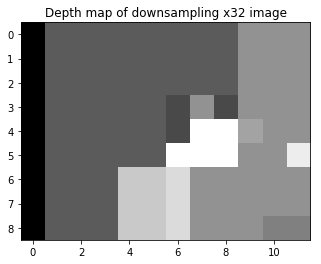

In [12]:
depth=solveTsukuba(32)

Generating...
0:00:01
Solving...
0:00:03


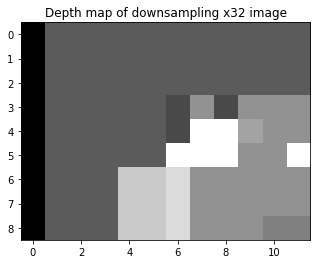

In [9]:
depth=solveTsukuba(32,True)

Generating...
0:00:07
Solving...
0:01:05


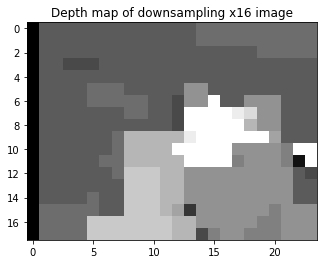

In [10]:
depth=solveTsukuba(16)

Generating...
0:00:07
Solving...
0:00:15


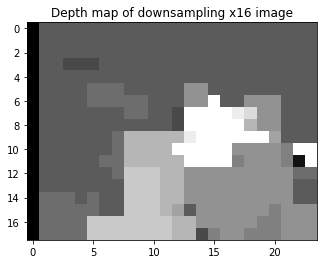

In [13]:
depth=solveTsukuba(16,True)

In [7]:
depth=solveTsukuba(8)

Generating...
0:00:45
Solving...


PulpSolverError: Pulp: Error while trying to execute C:\ProgramData\Anaconda3\lib\site-packages\pulp\solverdir\cbc\win\32\cbc.exe

Generating...
0:00:42
Solving...
0:01:29
Printing...


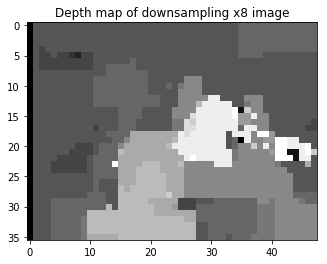

In [16]:
depth=solveTsukuba(8,True)

In [17]:
depth=solveTsukuba(4,True)

Generating...


MemoryError: 

For the smallest 2-3 instances we could solve the problem with this approach but only for those. We think for the larger instances this approach may work with utilizing a supercomputer, but we also suspect there are heuristic approaches that can get a reasonably good solution much faster.